# Feature Engineering with PySpark

## Exploratory data analysis

In [1]:
# Import libraries
import sys
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('p4-feature-engineering-with-pyspark').getOrCreate()
print(f'Spark version: {spark.version}')
print(f'system version: {sys.version_info}')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/06 23:10:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark version: 3.4.1
system version: sys.version_info(major=3, minor=9, micro=16, releaselevel='final', serial=0)


In [2]:
# Load data
data_file_path = 'datasets/2017_StPaul_MN_Real_Estate.csv'
df = spark.read.csv(data_file_path, header=True, inferSchema=True)
df.show(5)

23/08/06 23:10:12 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+-----+-------------------+--------------------+----------+----------+---------------+----------------+---------------+--------------+---------+---------------+-----------------+------------+--------------+----------+---------+-----------------+--------------------+------------+---------------+----------+---------+--------------------+--------------------+----------+------------------+---------------+----+--------------------+---------------+-----+----------+---------+------------------+-------+----------+----------+---------+------------------+--------------------+-----+------------------+--------------------+----------------+--------------+---------+------------+----------+----------+---------+---------------------+--------------------+---------+---------+-----------+-----------------+-----+----------+--------------------+---------+----------+---------+----------+---------+----------+---------+----------+--------+---------------+-----------------+--------------+-----------------+

In [3]:
print(f"Number of rows: {df.count()}")
print(f"Number of columns: {len(df.columns)}")

Number of rows: 5000
Number of columns: 74


### Defining a problem

#### What are we predicting?

In [4]:
# Select our dependent variable
Y_df = df.select(['SALESCLOSEPRICE'])
# Display summary statistics
Y_df.describe().show()

+-------+------------------+
|summary|   SALESCLOSEPRICE|
+-------+------------------+
|  count|              5000|
|   mean|       262804.4668|
| stddev|140559.82591998563|
|    min|             48000|
|    max|           1700000|
+-------+------------------+



#### Verifying Data load

In [5]:
def check_load(df, num_records, num_columns):
    # Takes a dataframe and compares record and column counts to input
    # Message to return if the critera below aren't met
    message = 'Validation Failed'
    # Check number of records
    if num_records == df.count():
        # Check number of columns
        if num_columns == len(df.columns):
            # Success message
            message = 'Validation Passed'
    return message

# Print the data validation message
print(check_load(df, 5000, 74))

Validation Passed


#### Verifying DataTypes

In [6]:
validation_dict = {'ASSESSMENTPENDING': 'string',
                    'AssessedValuation': 'double',
                    'AssociationFee': 'bigint',
                    'AssumableMortgage': 'string',
                    'SQFTBELOWGROUND': 'bigint'}

In [7]:
# create list of actual dtypes to check
actual_dtypes_list = df.dtypes
print(actual_dtypes_list)

# Iterate through the list of actual dtypes tuples
for attribute_tuple in actual_dtypes_list:
  
  # Check if column name is dictionary of expected dtypes
  col_name = attribute_tuple[0]
  if col_name in validation_dict:

    # Compare attribute types
    col_type = attribute_tuple[1]
    if col_type == validation_dict[col_name]:
      print(col_name + ' has expected dtype.')

[('No.', 'int'), ('MLSID', 'string'), ('StreetNumberNumeric', 'int'), ('streetaddress', 'string'), ('STREETNAME', 'string'), ('PostalCode', 'int'), ('StateOrProvince', 'string'), ('City', 'string'), ('SalesClosePrice', 'int'), ('LISTDATE', 'string'), ('LISTPRICE', 'int'), ('LISTTYPE', 'string'), ('OriginalListPrice', 'int'), ('PricePerTSFT', 'double'), ('FOUNDATIONSIZE', 'int'), ('FENCE', 'string'), ('MapLetter', 'string'), ('LotSizeDimensions', 'string'), ('SchoolDistrictNumber', 'string'), ('DAYSONMARKET', 'int'), ('offmarketdate', 'string'), ('Fireplaces', 'int'), ('RoomArea4', 'string'), ('roomtype', 'string'), ('ROOF', 'string'), ('RoomFloor4', 'string'), ('PotentialShortSale', 'string'), ('PoolDescription', 'string'), ('PDOM', 'int'), ('GarageDescription', 'string'), ('SQFTABOVEGROUND', 'int'), ('Taxes', 'int'), ('RoomFloor1', 'string'), ('RoomArea1', 'string'), ('TAXWITHASSESSMENTS', 'double'), ('TAXYEAR', 'int'), ('LivingArea', 'int'), ('UNITNUMBER', 'string'), ('YEARBUILT', 'i

### Visually Inspecting Data / EDA

#### Using `corr()`

In [8]:
columns = ['FOUNDATIONSIZE',
            'DAYSONMARKET',
            'FIREPLACES',
            'PDOM',
            'SQFTABOVEGROUND',
            'TAXES',
            'TAXWITHASSESSMENTS',
            'TAXYEAR',
            'LIVINGAREA',
            'YEARBUILT',
            'ACRES',
            'BACKONMARKETDATE',
            'BATHSFULL',
            'BATHSHALF',
            'BATHQUARTER',
            'BATHSTHREEQUARTER',
            'BATHSTOTAL',
            'BEDROOMS',
            'SQFTBELOWGROUND',
            'ASSOCIATIONFEE',
            'ASSESSEDVALUATION']

In [9]:
# print out data types of each column
for col in columns:
    print(col, df.select(col).dtypes)

FOUNDATIONSIZE [('FOUNDATIONSIZE', 'int')]
DAYSONMARKET [('DAYSONMARKET', 'int')]
FIREPLACES [('FIREPLACES', 'int')]
PDOM [('PDOM', 'int')]
SQFTABOVEGROUND [('SQFTABOVEGROUND', 'int')]
TAXES [('TAXES', 'int')]
TAXWITHASSESSMENTS [('TAXWITHASSESSMENTS', 'double')]
TAXYEAR [('TAXYEAR', 'int')]
LIVINGAREA [('LIVINGAREA', 'int')]
YEARBUILT [('YEARBUILT', 'int')]
ACRES [('ACRES', 'double')]
BACKONMARKETDATE [('BACKONMARKETDATE', 'string')]
BATHSFULL [('BATHSFULL', 'int')]
BATHSHALF [('BATHSHALF', 'int')]
BATHQUARTER [('BATHQUARTER', 'int')]
BATHSTHREEQUARTER [('BATHSTHREEQUARTER', 'int')]
BATHSTOTAL [('BATHSTOTAL', 'int')]
BEDROOMS [('BEDROOMS', 'int')]
SQFTBELOWGROUND [('SQFTBELOWGROUND', 'int')]
ASSOCIATIONFEE [('ASSOCIATIONFEE', 'int')]
ASSESSEDVALUATION [('ASSESSEDVALUATION', 'double')]


In [10]:
df.select('BACKONMARKETDATE').show(10)

+----------------+
|BACKONMARKETDATE|
+----------------+
|            null|
|            null|
|            null|
|            null|
|            null|
|            null|
|            null|
|            null|
|            null|
|            null|
+----------------+
only showing top 10 rows



In [11]:
from pyspark.sql.types import DoubleType
# catch BACKONMARKETDATE column to double type
df = df.withColumn("BACKONMARKETDATE", df["BACKONMARKETDATE"].cast(DoubleType()))

In [12]:
# Name and value of col with max corr
corr_max = 0
corr_max_col = columns[0]

# Loop to check all columns contained in list
for col in columns:
    # Check the correlation of a pair of columns
    corr_val = df.corr(col, 'SALESCLOSEPRICE')
    # Logic to compare corr_max with current corr_val
    if corr_val > corr_max:
        # Update the column name and corr value
        corr_max = corr_val
        corr_max_col = col

print(corr_max_col)

LIVINGAREA


#### Using Visualizations: distplot

/var/folders/66/6rbnzyf91v9d5v8nb46hmn0h0000gn/T/ipykernel_54933/3639557235.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pandas_df)


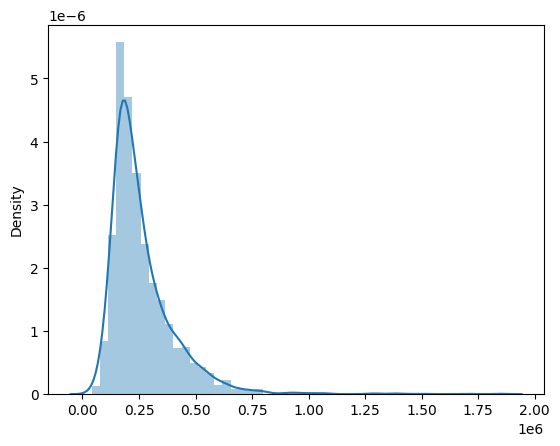

[Row(skewness(LISTPRICE)=2.790448093916559)]


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select a single column and sample and convert to pandas
sample_df = df.select(['LISTPRICE']).sample(False, 0.5, 42)
pandas_df = sample_df.toPandas()

# Plot distribution of pandas_df and display plot
sns.distplot(pandas_df)
plt.show()

# Import skewness function
from pyspark.sql.functions import skewness

# Compute and print skewness of LISTPRICE
print(df.agg({'LISTPRICE': 'skewness'}).collect())

#### Using Visualizations: lmplot

/Users/ngohongthai/miniconda3/envs/data-engineering/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


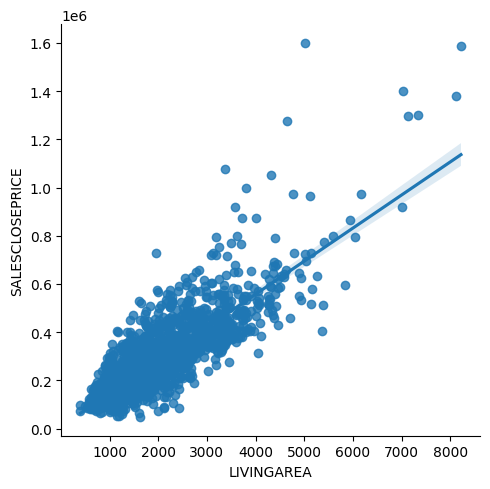

In [14]:
# Select a the relevant columns and sample
sample_df = df.select(['SALESCLOSEPRICE', 'LIVINGAREA']).sample(False, 0.5, 42)

# Convert to pandas dataframe
pandas_df = sample_df.toPandas()

# Linear model plot of pandas_df
sns.lmplot(x='LIVINGAREA', y='SALESCLOSEPRICE', data=pandas_df)
plt.show()

## Wrangling with Spark Functions

### Dropping data

#### Droping a list of columns

In [15]:
# Show top 30 records
df.show(30)

# List of columns to remove from dataset
cols_to_drop = ['STREETNUMBERNUMERIC', 'LOTSIZEDIMENSIONS']

# Drop columns in list
df = df.drop(*cols_to_drop)

+---+-----+-------------------+--------------------+----------+----------+---------------+----------------+---------------+---------------+---------+---------------+-----------------+------------+--------------+----------------+---------+--------------------+--------------------+------------+---------------+----------+---------+--------------------+--------------------+----------+------------------+--------------------+----+--------------------+---------------+-----+----------+---------+------------------+-------+----------+----------+---------+--------------------+--------------------+-----+------------------+--------------------+----------------+--------------------+---------+--------------------+----------+----------+---------+---------------------+--------------------+---------+---------+-----------+-----------------+-----+----------+--------------------+---------+----------+---------+----------+---------+----------+---------+----------+--------+---------------+-----------------+--

#### Using text filters to remove records